<a href="https://colab.research.google.com/github/luigiselmi/dl_remote_sensing/blob/main/bigearthnet_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BigEarthNet model
In this notebook we implement a deep learning model for the classification of pixels in satellite images. We use the same model implemented for the EPFL Building footprints. The dataset for training the model is [BigEarthNet](https://bigearth.net/#downloads). The original TIFF images for the Sentinel-2 bands and the relative masks have been transformed into PNG files.

In [1]:
import os, shutil, pathlib
from pathlib import Path
import requests
import urllib
import urllib.request
from zipfile import ZipFile
import matplotlib.pyplot as plt
from skimage import io
from skimage import exposure
from skimage.io import imsave, imread
import numpy as np
from sklearn.metrics import jaccard_score
import tensorflow as tf
import keras
from keras import layers
#from tensorflow.keras.utils import image_dataset_from_directory
#from tf.keras.preprocessing import image_dataset_from_directory
import warnings
warnings.filterwarnings('ignore')
print("NumPy version: %s"%np.__version__)
print('Tensorflow version: {:s}'.format(tf.__version__))
print('Keras version. {}'.format(keras.__version__))

NumPy version: 2.0.2
Tensorflow version: 2.18.0
Keras version. 3.8.0


In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Your runtime has 13.6 gigabytes of available RAM



## The BigEarthNet dataset
The RGB PNG files and the corresponding masks that we have prepared are available as zip files. They can be downloaded from an S3 bucket on AWS

In [3]:
DATADIR = '.'
masks_presigned_url = 'https://selmilab-bucket.s3.eu-south-1.amazonaws.com/bigearthnet_mask_pngs.zip'

In [4]:
r = requests.get(masks_presigned_url)
masks_file_path = f'bigearthnet_masks.zip'
with open(masks_file_path, 'wb') as f:
        f.write(r.content)

In [5]:
images_presigned_url = 'https://selmilab-bucket.s3.eu-south-1.amazonaws.com/bigearthnet_pngs.zip'

In [6]:
r = requests.get(images_presigned_url)
images_file_path = f'bigearthnet_rgb.zip'
with open(images_file_path, 'wb') as f:
        f.write(r.content)

In [7]:
with ZipFile(f'{DATADIR}/bigearthnet_masks.zip', 'r') as zipObj:
   zipObj.extractall(path=f'{DATADIR}/masks/')

In [8]:
with ZipFile(f'{DATADIR}/bigearthnet_rgb.zip', 'r') as zipObj:
   zipObj.extractall(path=f'{DATADIR}/images/')

In [9]:
from PIL import Image
img = Image.open('images/R008_T31UGR_00_00_20180508.png')
img.size

(120, 120)

In [11]:
mask = Image.open('masks/R008_T31UGR_00_00_20180508_mask.png')
mask.size

(120, 120)

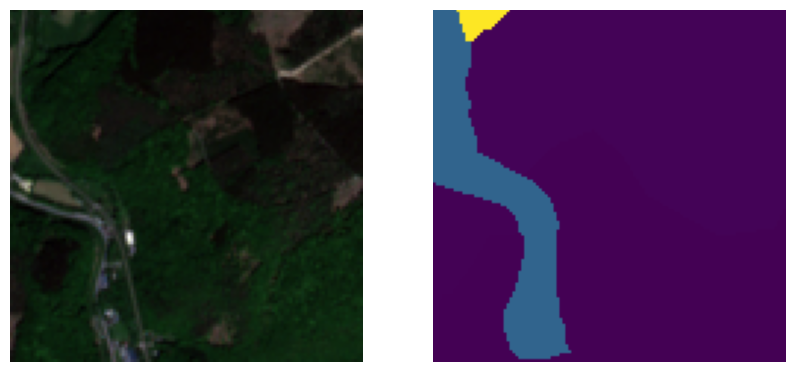

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
ax[0].axis("off")
ax[1].axis("off")
ax[0].imshow(img)
ax[1].imshow(mask)

In [13]:
img_dir = pathlib.Path('images/')
img_file_list = [os.path.join(img_dir, fname) for fname in os.listdir(img_dir) if fname.endswith(".png")]
img_paths = sorted(img_file_list)
print('Number of images: {:d}'.format(len(img_paths)))

Number of images: 28766


In [14]:
mask_dir = pathlib.Path('masks/')
mask_file_list = [os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir) if fname.endswith("_mask.png")]
mask_paths = sorted(mask_file_list)
print('Number of masks: {:d}'.format(len(mask_paths)))

Number of masks: 28766


In [15]:
def plot_raster(ax, list_images):
  index = 0
  for col in range(0, fig_cols):
    for row in range(0, fig_rows):
      img_natcol = io.imread(list_images[index])
      ax[row, col].set_axis_off()
      ax[row, col].imshow(img_natcol)
      index += 1

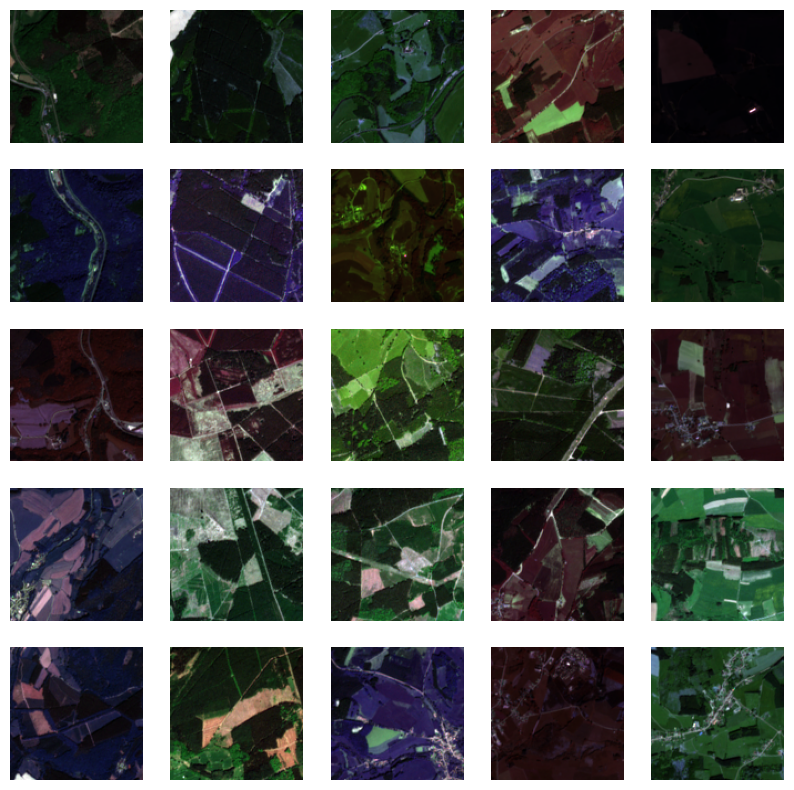

In [16]:
fig_rows = 5
fig_cols = 5
num_imgs = fig_rows * fig_cols
fig, ax = plt.subplots(nrows=fig_rows, ncols=fig_cols, figsize=(10, 10))
plot_raster(ax, img_paths[:num_imgs])

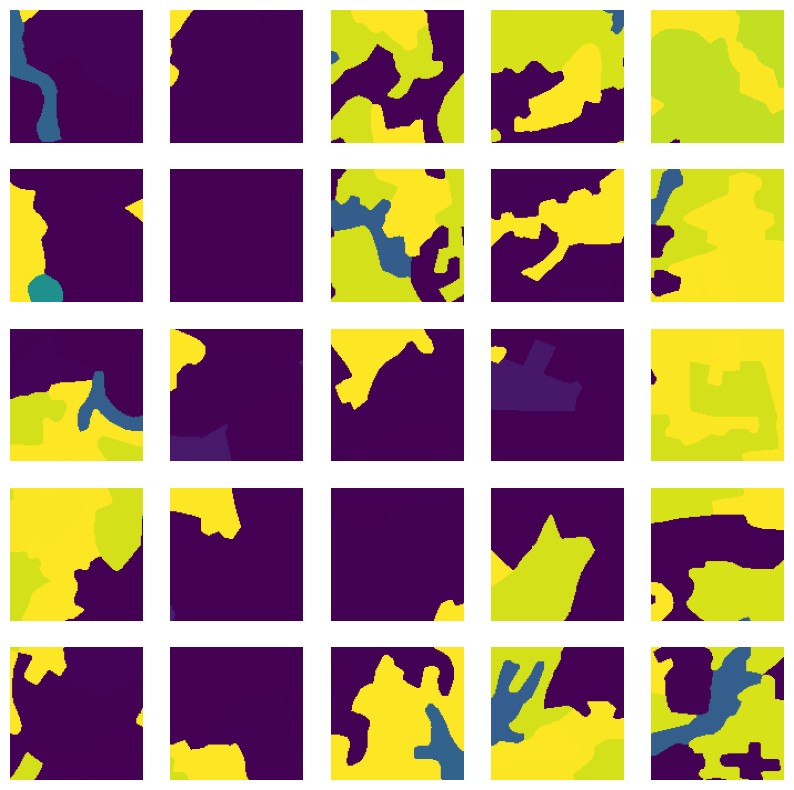

In [ ]:
fig, ax = plt.subplots(nrows=fig_rows, ncols=fig_cols, figsize=(10, 10))
plot_raster(ax, mask_paths[:num_imgs])

## Data loading
We load the images and the masks into two datasets. The correspondance between an image and its mask is mantained.

In [ ]:
#import random
#random.Random(1337).shuffle(img_paths)
#random.Random(1337).shuffle(mask_paths)

In [17]:
total_num_imgs = int(len(img_paths))
print('Total number of images: {:d}'.format(total_num_imgs))

Total number of images: 28766


We check that the image with a casual index, e.g. 100, corresponds with the mask with the same index

In [18]:
img_paths[100]

'images/R008_T31UGR_01_10_20180508.png'

In [19]:
mask_paths[100]

'masks/R008_T31UGR_01_10_20180508_mask.png'

In [20]:
len(img_paths), len(mask_paths)

(28766, 28766)

We split the data into three parts: train, validation, and test

In [23]:
num_train_images = 20000
num_val_images = 5000
num_test_images = total_num_imgs - num_train_images - num_val_images
print('Number of training images: {:d}\nNumber of validation images: {:d}\nNumber of test images: {:d}'.format(num_train_images, num_val_images, num_test_images))

Number of training images: 20000
Number of validation images: 5000
Number of test images: 3766


## Splitting the dataset into train, validation, and test sub-folders
Since the number of images is quite large we cannot put all of them in memory using a tensor, we have to load the data using a TensorFlow Dataset object. The 1st step is to move the image and mask files into sud-folders for training, validation and test

In [98]:
def make_subset(base_dir, dest_dir, start_index, end_index):
    '''
    This function moves the files in the base_dir to the destination folder.
    The base directory and the destination folder are passed ar strings.
    If the destination folder is not empty the file names will be returned.
    '''
    target_paths = []
    file_list = sorted([pathlib.Path(os.path.join(base_dir, fname)) for fname in os.listdir(base_dir) if fname.endswith(".png")])
    dest_dir_path = pathlib.Path(dest_dir)
    if not os.path.exists(dest_dir):
      os.makedirs(dest_dir)
      for fpath in file_list[start_index:end_index]:
        target_path = dest_dir_path / fpath.name
        shutil.move(src=fpath, dst=target_path)
        target_paths.append(target_path)
    else:
      print('Destination folder already exists')
      base_dir = dest_dir
      file_list = sorted([pathlib.Path(os.path.join(base_dir, fname)) for fname in os.listdir(base_dir) if fname.endswith(".png")])
      for fpath in file_list[start_index:end_index]:
        target_path = dest_dir_path / fpath.name
        target_paths.append(target_path)
    return target_paths

In [102]:
train_images_paths = make_subset('images', 'images/train', start_index=0, end_index=num_train_images)
len(train_images_paths)

Destination folder already exists


20000

In [103]:
val_images_paths = make_subset('images', 'images/validation', start_index=0, end_index=num_val_images)
len(val_images_paths)

Destination folder already exists


5000

In [104]:
test_images_paths = make_subset('images', 'images/test', start_index = 0, end_index=num_test_images)
len(test_images_paths)

Destination folder already exists


3766

In [105]:
train_masks_paths = make_subset('masks', 'masks/train', start_index=0, end_index=num_train_images)
len(train_masks_paths)

Destination folder already exists


20000

In [106]:
val_masks_paths = make_subset('masks', 'masks/validation', start_index=0, end_index=num_val_images)
len(val_masks_paths)

Destination folder already exists


5000

In [107]:
test_masks_paths = make_subset('masks', 'masks/test', start_index = 0, end_index=num_test_images)
len(test_masks_paths)

Destination folder already exists


3766

In [108]:
train_images_paths[100]

PosixPath('images/train/R008_T31UGR_01_10_20180508.png')

In [109]:
train_masks_paths[100]

PosixPath('masks/train/R008_T31UGR_01_10_20180508_mask.png')

## TensorFlow datasets
We load the image files in each subfolder in a  [TensorFlow dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset), train, validation, and test, using the image_dataset_from_directory() utility function. The utility function shuffles the files by default so we set the seed value that will be used for the masks datasets as well in order to keep the correspondance between the images and the masks between the datasets:

### Images datasets

In [142]:
train_images_dataset = tf.keras.preprocessing.image_dataset_from_directory('images/train', labels=None, seed=1337, image_size=(120, 120), batch_size=32)

Found 20000 files.


In [37]:
print('Number of train batches: ', len(train_images_dataset))

Number of train batches:  625


In [38]:
for data_batch in train_images_dataset:
  print("data batch shape:", data_batch.shape)
  break

data batch shape: (32, 120, 120, 3)


In [39]:
val_images_dataset = tf.keras.preprocessing.image_dataset_from_directory('images/validation', labels=None, seed=1337, image_size=(120, 120), batch_size=32)

Found 5000 files.


In [40]:
print('Number of validation batches: ', len(val_images_dataset))

Number of validation batches:  157


In [41]:
test_images_dataset = tf.keras.preprocessing.image_dataset_from_directory('images/test', labels=None, seed=1337, image_size=(120, 120), batch_size=32)

Found 3766 files.


In [42]:
print('Number of test batches: ', len(test_images_dataset))

Number of test batches:  118


### Masks datasets

In [143]:
train_masks_dataset = tf.keras.preprocessing.image_dataset_from_directory('masks/train', labels=None, color_mode='grayscale', seed=1337, image_size=(120, 120), batch_size=32)

Found 20000 files.


In [144]:
print('Number of train mask batches: ', len(train_masks_dataset))

Number of train mask batches:  625


In [145]:
val_masks_dataset = tf.keras.preprocessing.image_dataset_from_directory('masks/validation', labels=None, color_mode='grayscale', seed=1337, image_size=(120, 120), batch_size=32)

Found 5000 files.


In [146]:
test_masks_dataset = tf.keras.preprocessing.image_dataset_from_directory('masks/test', labels=None, color_mode='grayscale', seed=1337, image_size=(120, 120), batch_size=32)

Found 3766 files.


In [147]:
for data_batch in train_masks_dataset:
  print("data batch shape:", data_batch.shape)
  data_batch
  break

data batch shape: (32, 120, 120, 1)


## Train dataset
a dataset of images with the corresponding masks

In [148]:
train_dataset = tf.data.Dataset.zip((train_images_dataset, train_masks_dataset))

## Validation dataset
Validation images with the corresponding masks

In [149]:
val_dataset = tf.data.Dataset.zip((val_images_dataset, val_masks_dataset))

## Test dataset
Test images with the corresponding masks

In [166]:
test_dataset = tf.data.Dataset.zip((test_images_dataset, test_masks_dataset))

## Building the encoder-decoder model

In [162]:
image_height = 120
image_width = 120

def build_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

In [163]:
CORINE_CLASSES = 19
model = build_model(img_size=(120,120), num_classes=CORINE_CLASSES)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 120, 120,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 60, 60,    │        896 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 60,    │        128 │ conv2d_27[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_45       │ (None, 60, 60,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_46       │ (None, 60, 60,    │          0 │ activation_45[0]… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_18 │ (None, 60, 60,    │      2,400 │ activation_46[0]… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 60,    │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_47       │ (None, 60, 60,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_19 │ (None, 60, 60,    │      4,736 │ activation_47[0]… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 60,    │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 30, 30,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 30, 30,    │      2,112 │ activation_45[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_21 (Add)        │ (None, 30, 30,    │          0 │ max_pooling2d_9[… │
│                     │ 64)               │            │ conv2d_28[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_48       │ (None, 30, 30,    │          0 │ add_21[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_20 │ (None, 30, 30,    │      8,896 │ activation_48[0]… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 30,    │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_49       │ (None, 30, 30,    │          0 │ batch_normalizat

 Total params: 2,063,603 (7.87 MB)

 Trainable params: 2,059,827 (7.86 MB)

 Non-trainable params: 3,776 (14.75 KB)

In [164]:
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy", #)
              metrics=['accuracy'])

callbacks = [
    keras.callbacks.ModelCheckpoint("bigearthnet_v2.keras",
    save_best_only=True)
]

In [165]:
history = model.fit(train_dataset,
                    epochs=100,
                    callbacks=callbacks,
                    batch_size=32,
                    validation_data=val_dataset)

Epoch 1/100


ValueError: Arguments `target` and `output` must have the same shape up until the last dimension: target.shape=(None, 120, 120), output.shape=(None, 128, 128, 19)